# evolution-strategy-agent

Gradient descent is not the only option when learning optimal model parameters. Evolution Strategies (ES) works out well in the cases where we don’t know the precise analytic form of an objective function or cannot compute the gradients directly. This post dives into several classic ES methods, as well as how ES can be used in deep reinforcement learning.
Stochastic gradient descent is a universal choice for optimizing deep learning models. However, it is not the only option. With black-box optimization algorithms, you can evaluate a target function f(x):ℝn→ℝ
f
(
x
)
:
R
n
→
R
, even when you don’t know the precise analytic form of f(x)
f
(
x
)
and thus cannot compute gradients or the Hessian matrix. Examples of black-box optimization methods include Simulated Annealing, Hill Climbing and Nelder-Mead method.

Evolution Strategies (ES) is one type of black-box optimization algorithms, born in the family of Evolutionary Algorithms (EA). In this post, I would dive into a couple of classic ES methods and introduce a few applications of how ES can play a role in deep reinforcement learning.

What are Evolution Strategies?
Simple Gaussian Evolution Strategies
Covariance Matrix Adaptation Evolution Strategies (CMA-ES)
Updating the Mean
Controlling the Step Size
Adapting the Covariance Matrix
Natural Evolution Strategies
Natural Gradients
Estimation using Fisher Information Matrix
NES Algorithm
Applications: ES in Deep Reinforcement Learning
OpenAI ES for RL
Exploration with ES
CEM-RL
Extension: EA in Deep Learning
Hyperparameter Tuning: PBT
Network Topology Optimization: WANN
References

https://lilianweng.github.io/lil-log/2019/09/05/evolution-strategies.html

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import time
tf.compat.v1.disable_eager_execution()
sns.set()

In [5]:
import pkg_resources
import types


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print('{}=={}'.format(*r))

pyspark==3.1.1
tensorflow==2.5.0
seaborn==0.11.1
pandas==1.2.5
numpy==1.19.5
matplotlib==3.4.2


In [6]:
df = pd.read_csv('/Users/gkumargaur/workspace/python/gitprojects/Stock-Prediction-Models/dataset/GOOG-year.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2020-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2020-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2020-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2020-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


In [7]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        return decision

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [8]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, window_size, trend, skip, initial_money):
        self.model = model
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))
        return np.argmax(decision[0])
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = self.get_state(0)
        inventory = []
        quantity = 0
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                starting_money -= close[t]
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                starting_money += self.trend[t]

            state = next_state
        return ((starting_money - initial_money) / initial_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = self.get_state(0)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

In [11]:
close = df.Close.values.tolist()
window_size = 30
skip = 1
initial_money = 10000

model = Model(input_size = window_size, layer_size = 500, output_size = 3)
agent = Agent(model = model, 
              window_size = window_size,
              trend = close,
              skip = skip,
              initial_money = initial_money)
agent.fit(iterations = 500, checkpoint = 10)

iter 10. reward: 17.130849
iter 20. reward: 21.445799
iter 30. reward: 22.897298
iter 40. reward: 22.441996
iter 50. reward: 22.895750
iter 60. reward: 25.649650
iter 70. reward: 24.456400
iter 80. reward: 28.567402
iter 90. reward: 29.357353
iter 100. reward: 29.056553
iter 110. reward: 29.782852
iter 120. reward: 31.807852
iter 130. reward: 31.161352
iter 140. reward: 33.731852
iter 150. reward: 33.067751
iter 160. reward: 33.375652
iter 170. reward: 32.895251
iter 180. reward: 34.883650
iter 190. reward: 33.853752
iter 200. reward: 34.903151
iter 210. reward: 35.275950
iter 220. reward: 33.371750
iter 230. reward: 33.385450
iter 240. reward: 33.940949
iter 250. reward: 34.031349
iter 260. reward: 33.813851
iter 270. reward: 34.191051
iter 280. reward: 34.536351
iter 290. reward: 35.141451
iter 300. reward: 34.522451
iter 310. reward: 35.263751
iter 320. reward: 32.770151
iter 330. reward: 34.812552
iter 340. reward: 33.046252
iter 350. reward: 34.676052
iter 360. reward: 34.369652
i

In [12]:
states_buy, states_sell, total_gains, invest = agent.buy()

day 0: buy 1 unit at price 768.700012, total balance 9231.299988
day 1, sell 1 unit at price 762.130005, investment -0.854691 %, total balance 9993.429993,
day 2: buy 1 unit at price 762.020020, total balance 9231.409973
day 3: buy 1 unit at price 782.520020, total balance 8448.889953
day 4, sell 1 unit at price 790.510010, investment 3.738746 %, total balance 9239.399963,
day 5, sell 1 unit at price 785.309998, investment 0.356538 %, total balance 10024.709961,
day 6: buy 1 unit at price 762.559998, total balance 9262.149963
day 7: buy 1 unit at price 754.020020, total balance 8508.129943
day 11: buy 1 unit at price 771.229980, total balance 7736.899963
day 12: buy 1 unit at price 760.539978, total balance 6976.359985
day 13: buy 1 unit at price 769.200012, total balance 6207.159973
day 15, sell 1 unit at price 760.989990, investment -0.205886 %, total balance 6968.149963,
day 17: buy 1 unit at price 768.239990, total balance 6199.909973
day 19: buy 1 unit at price 758.039978, total b

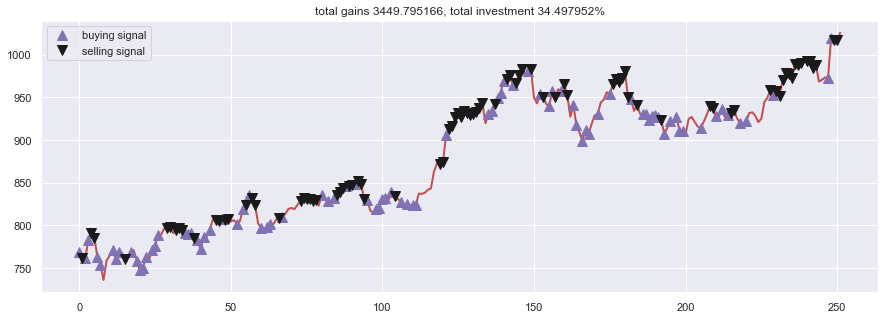

In [13]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()